In [1]:
import rasterio
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
os.getcwd()

'/home/andre/Documents/gridfinder/predictive-mapping-global-power'

In [3]:
base_path = os.getcwd()+'/Data'
dataset = '/costs_extended/europe' # ie. '/protected_areas', '/pop'
file_path = base_path+dataset
print(file_path)

/home/andre/Documents/gridfinder/predictive-mapping-global-power/Data/costs_extended/europe


[0.1        0.11111111 0.125      0.14285715 0.16666667 0.2
 0.22222222 0.25       0.2857143  0.33333334 0.5        0.5714286
 0.66666669 1.         2.         3.         4.         6.        ]


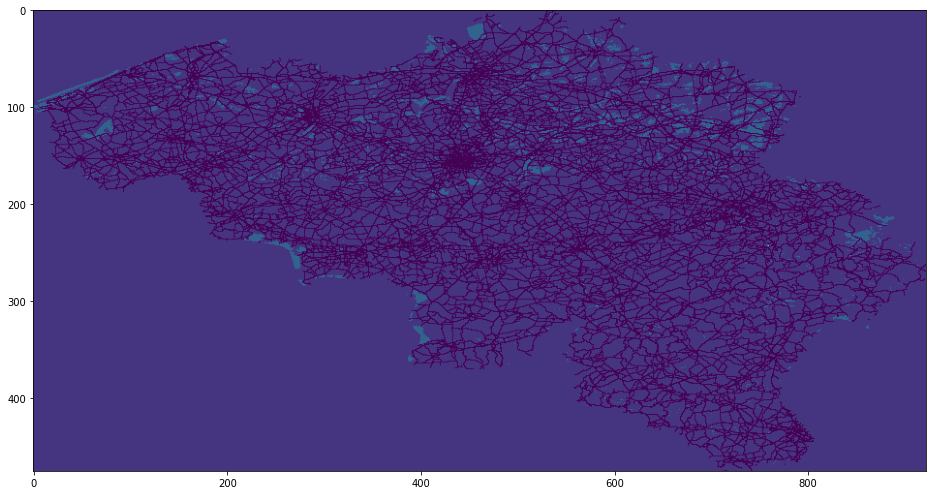

(array([431018,   7847,      6,      1]),
 array([0.1  , 1.575, 3.05 , 4.525, 6.   ]))

In [6]:
s = rasterio.open(file_path+'/BEL.tif')
slope = s.read(1)
print(np.unique(slope))
plt.figure(figsize=(16,9))
plt.imshow(slope)
plt.show()
np.histogram(slope,bins=4)

In [ ]:
s = rasterio.open(file_path+'/.tif')
slope = s.read(1)
print(slope.shape, type(slope))
slope[slope <= 20] = 1
slope[(slope > 20) & (slope <= 30)] = 2
slope[slope > 30] = 3

plt.imshow(slope)
plt.show()
np.histogram(slope,bins=10)tm

In [110]:
a = np.array([[1,2,3],[4,5,6],[7,8,9]])
b = np.array([[2,2,2],[3,3,3],[4,4,4]])
z = np.array([[1,1,1],[1,0,1],[1,0,1]])
c = np.multiply(a+b,z)
c

array([[ 3,  4,  5],
       [ 7,  0,  9],
       [11,  0, 13]])

In [18]:
c[c <= 10] = 4
c[(c > 10) & (c <= 20)] = 15
c[(c > 20) & (c <= 40)] = 32
c

array([[ 4,  4,  4],
       [15, 15, 15],
       [32, 32, 32]])

In [99]:
import csv

with open('names.csv', 'w', newline='') as csvfile:
    fieldnames = ['first_name', 'age']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    writer.writeheader()
    writer.writerow({'first_name': 'Baked', 'age': None})
    writer.writerow({'first_name': 'Son', 'age': '12'})
    writer.writerow({'first_name': 'Lovely', 'age': '13;15'})
    writer.writerow({'first_name': 'Wonderful', 'age': 16})
    writer.writerow({'first_name': 'Sonderful', 'age': 'low'})

In [100]:
with open('names.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        print(row['first_name'], row['age'])

Baked 
Son 12
Lovely 13;15
Wonderful 16
Sonderful low


In [101]:
import geopandas as gpd
import pandas as pd

In [106]:
df = pd.read_csv('names.csv')
df["weight"] = 1
df.age = df.age.apply(lambda x: x.split(';')[0] if (type(x) == str) else x)
df.age = pd.to_numeric(df.age, errors='coerce')
#df.age = df.age.apply(lambda x: 0 if x in ("low", "medium") else x)
#df.age = pd.to_numeric(df.age)
df.loc[df["age"] > 12, "weight"] = 0
df.dropna()
df.head()

,first_name,age,weight
0,Baked,NaN,1
1,Son,12.0,1
2,Lovely,13.0,0
3,Wonderful,16.0,0
4,Sonderful,NaN,1


In [113]:
base_path = os.getcwd()+'/Data'
dataset = '/costs_extended/europe/'
file_path = base_path+dataset
print(file_path)

/home/andre/Documents/gridfinder/predictive-mapping-global-power/Data/costs_extended/europe/


In [128]:
costs_roads_in = file_path+'roads/PRT.tif'
costs_protected_areas_in = file_path+'protected_areas/PRT.tif'
costs_slope_in = file_path+'slope/PRT.tif'
costs_hv_in = file_path+'hv/PRT.tif'

r = 1
pa = 0.5
s = 0

costs_roads_ra = rasterio.open(costs_roads_in)
costs_roads = costs_roads_ra.read(1) * r

costs_protected_areas_ra = rasterio.open(costs_protected_areas_in)
costs_protected_areas = costs_protected_areas_ra.read(1) * pa

costs_slope_ra = rasterio.open(costs_slope_in)
costs_slope = costs_slope_ra.read(1) * s

costs_hv_ra = rasterio.open(costs_hv_in)
costs_hv = costs_hv_ra.read(1)

# Elementwise multiplication of HV-lines to properly set all hv containing cells
# to zero
costs = np.multiply(costs_roads + costs_protected_areas + costs_slope, costs_hv)

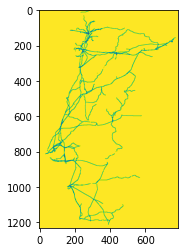

In [130]:
plt.imshow(costs_hv)

In [185]:
country = 'CZE'

grid_in = base_path+f'/ground_truth/europe/{country}.tif'
grid_buff_in = base_path+f'/ground_truth_buffered/europe/{country}.tif'
guess_in = base_path+f'/mv/europe/base/{country}.tif'
hv_in = base_path+f'/costs_extended/europe/hv/{country}.tif'
admin = os.getcwd()+'/admin_boundaries/europe_trimmed.gpkg'

admin = gpd.read_file(admin)
code = 'adm0_a3'
aoi_in = admin.loc[admin[code] == f'{country}']

def positives(guesses, truths):
    """Calculate true positives, used by accuracy().

    Parameters
    ----------
    guesses : numpy array
        Output from model.
    truths : numpy array
        Truth feature converted to array.

    Returns
    -------
    tp : float
        Ratio of true positives.
    """

    yes_guesses = 0
    yes_guesses_correct = 0
    rows = guesses.shape[0]
    cols = guesses.shape[1]

    for x in range(0, rows):
        for y in range(0, cols):
            guess = guesses[x, y]
            truth = truths[x, y]
            if guess == 1:
                yes_guesses += 1
                if guess == truth:
                    yes_guesses_correct += 1

    tp = yes_guesses_correct
    fp = yes_guesses - yes_guesses_correct

    return tp, fp


def negatives(guesses, truths):
    """Calculate false negatives, used by accuracy().

    Parameters
    ----------
    guesses : numpy array
        Output from model.
    truths : numpy array
        Truth feature converted to array.

    Returns
    -------
    fn : float
        Ratio of false negatives.
    """

    actual_grid = 0
    actual_grid_missed = 0

    rows = guesses.shape[0]
    cols = guesses.shape[1]

    for x in range(0, rows):
        for y in range(0, cols):
            guess = guesses[x, y]
            truth = truths[x, y]

            if truth == 1:
                actual_grid += 1
                if guess != truth:
                    found = False
                    for i in range(-5, 6):
                        for j in range(-5, 6):
                            if i == 0 and j == 0:
                                continue

                            shift_x = x + i
                            shift_y = y + j
                            if shift_x < 0 or shift_y < 0:
                                continue
                            if shift_x >= rows or shift_y >= cols:
                                continue

                            other_guess = guesses[shift_x, shift_y]
                            if other_guess == 1:
                                found = True
                    if not found:
                        actual_grid_missed += 1

    fn = actual_grid_missed

    return fn

def flip_arr_values(arr):
    arr[arr == 1] = 2
    arr[arr == 0] = 1
    arr[arr == 2] = 0
    return arr

In [187]:
if isinstance(aoi_in, gpd.GeoDataFrame):
    aoi = aoi_in
else:
    aoi = gpd.read_file(aoi_in)

guess = rasterio.open(guess_in)
guesses = guess.read(1)

g = rasterio.open(grid_in)
grid_raster = g.read(1)
grid_raster = flip_arr_values(grid_raster)

g_buff = rasterio.open(grid_buff_in)
grid_buff_raster = g_buff.read(1)
grid_buff_raster = flip_arr_values(grid_buff_raster)

hv = rasterio.open(hv_in)
hv_raster = hv.read(1)

#guesses = np.multiply(guesses, hv_raster)
#grid_raster = np.multiply(grid_raster, hv_raster)
#grid_buff_raster = np.multiply(grid_buff_raster, hv_raster)

assert grid_raster.shape == grid_buff_raster.shape, "Ground truth rasters are not same shape"
assert guesses.shape ==  grid_raster.shape, "Shapes of guesses and groundt truth do not match"

tp, fp = positives(guesses, grid_buff_raster)
fn = negatives(guesses, grid_raster)

precision = tp/(tp+fp)
recall = tp/(tp+fn)
iou = tp/(tp+fp+fn)
print(tp, fp, fn, precision, recall, iou)

34363 29577 125 0.5374257116046294 0.9963755509162607 0.5363771169905565


In [ ]:
# 34363 29577 125 0.5374257116046294 0.9963755509162607 0.5363771169905565
# 12570 29577 198 0.2982418677485942 0.9844924812030075 0.29684732554020543

In [188]:
np.histogram(hv_raster)

(array([ 34755,      0,      0,      0,      0,      0,      0,      0,
             0, 923693]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

In [15]:
pop_raster = rasterio.open("./Data/pop/europe/FRA.tif")
pop = pop_raster.read(1)

In [18]:
a = "/Data/pop/base_10/"
b = "/Data/hv/base_10/"

In [20]:
a.split("/")[-2]

'base_10'

In [22]:
base = rasterio.open("Data/mv/europe/base_02/FRA.tif")
base_r = base.read(1)
filt = rasterio.open("Data/mv/europe/lccs_filtered/FRA.tif")
filt_r = filt.read(1)

In [27]:
np.count_nonzero(base_r)

274976

In [29]:
np.count_nonzero(filt_r)

275020